Epoch [1000/10000], Loss: 1.3533e-04
Epoch [2000/10000], Loss: 7.2535e-06
Epoch [3000/10000], Loss: 5.3173e-06
Epoch [4000/10000], Loss: 3.7520e-06
Epoch [5000/10000], Loss: 2.7427e-06
Epoch [6000/10000], Loss: 1.9826e-06
Epoch [7000/10000], Loss: 1.4527e-06
Epoch [8000/10000], Loss: 9.8832e-07
Epoch [9000/10000], Loss: 1.1432e-06
Epoch [10000/10000], Loss: 3.5638e-07


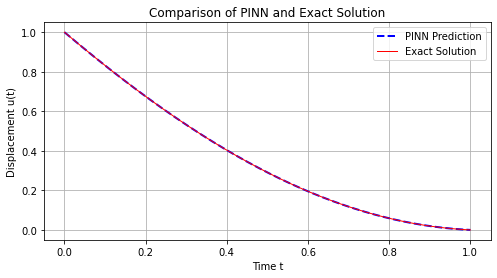

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define neural network model
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 50),   # Input layer: 1 neuron (x coordinate)
            nn.Tanh(),           # Activation function
            nn.Linear(50, 50),   # Hidden layer
            nn.Tanh(),
            nn.Linear(50, 1)    # Output layer: predicts y value
        )
    
    def forward(self, x):
        return self.net(x)

# Exact solution function (given in the problem)
def exact_solution(x):
    return -np.cos(x) + (np.cos(1) - 2)*np.sin(x)/np.sin(1) + 2

# Training parameters setup
num_epochs = 10000   # Number of training epochs
lr = 0.001           # Learning rate

# Initialize model and optimizer
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Generate training data
num_internal = 1000   # Number of internal points
x_internal = torch.linspace(0, 1, num_internal).view(-1, 1).requires_grad_(True)  # Internal points
x_bc = torch.tensor([[0.0], [1.0]], requires_grad=True)  # Boundary points

# Training loop
loss_history = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Forward pass: internal points
    y_pred = model(x_internal)
    
    # Compute first derivative
    dy_dx = torch.autograd.grad(
        y_pred, x_internal,
        grad_outputs=torch.ones_like(y_pred),
        create_graph=True
    )[0]
    
    # Compute second derivative
    d2y_dx2 = torch.autograd.grad(
        dy_dx, x_internal,
        grad_outputs=torch.ones_like(dy_dx),
        create_graph=True
    )[0]
    
    # PDE residual loss: y'' + y - 2 = 0
    pde_loss = torch.mean((d2y_dx2 + y_pred - 2)**2)
    
    # Boundary condition loss
    y0_pred = model(x_bc[0].view(1, -1))  # Prediction at x=0
    y1_pred = model(x_bc[1].view(1, -1))  # Prediction at x=1
    bc_loss = (y0_pred - 1)**2 + (y1_pred - 0)**2
    
    # Total loss
    total_loss = pde_loss + bc_loss
    
    # Backward propagation
    total_loss.backward()
    optimizer.step()
    
    # Record loss
    loss_history.append(total_loss.item())
    
    # Print loss every 1000 epochs
    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss.item():.4e}')


# Generate test data
x_test = torch.linspace(0, 1, 1000).view(-1, 1)
y_pred = model(x_test).detach().numpy()
y_exact = exact_solution(x_test.numpy())

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
plt.figure(figsize=(8, 4))
plt.plot(x_test, y_pred, 'b--', linewidth=2, label='PINN Prediction')
plt.plot(x_test, y_exact, 'r-', linewidth=1, label='Exact Solution')
plt.xlabel('Time t')
plt.ylabel('Displacement u(t)')
plt.legend()
plt.title('Comparison of PINN and Exact Solution')
plt.grid(True)
plt.show()

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
y_exact = y_exact.reshape(-1, 1)
y_p_pinn = y_pred
y_true = y_exact
R2_pinn = r2_score(y_p_pinn, y_true)
mae_pinn = mean_absolute_error(y_p_pinn, y_true)
rmse_pinn = mean_squared_error(y_p_pinn, y_true, squared=False)
inf_norm_pinn = np.linalg.norm(y_p_pinn - y_true, ord = np.inf)

print(f"R2_pinn: {R2_pinn}, mae_pinn: {mae_pinn}, rmse_pinn: {rmse_pinn}, inf_norm_pinn: {inf_norm_pinn}")

R2_pinn: 0.9999999941891089, mae_pinn: 2.2824115148978308e-05, rmse_pinn: 2.2907806851435453e-05, inf_norm_pinn: 2.6047229766845703e-05


In [3]:
import numpy as np
import pandas as pd

data_to_save = pd.DataFrame({
    'x': x_test.flatten(),
    'y_pred_pinn': y_p_pinn.flatten(),
    'y_exact': y_true.flatten()
})

data_to_save.to_csv('pinn_12.csv', index=False)
print(" pinn_12.csv")

数据已保存至 pinn_12.csv
